In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
import re

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Unpack experiments

In [2]:
# Specify what you're looking at
exp = 'default'

In [93]:
exp_dir = f'/Volumes/aronov-locker/Ching/barcodes/capacity/{exp}/'
N_inp = 2000
N_bar = 2000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [94]:
def get_reconstruct_stats(reconstruct, cache_states):
    argmax_v = np.argmax(reconstruct, axis=1)
    argmax_v = (argmax_v/N_inp)*num_states
    max_v = np.max(reconstruct, axis=1)
    threshold_scale = 1.
    threshold = reconstruct.mean()+threshold_scale*reconstruct.std()

    attractor_dist = []
    opt_attractor_dist = []
    opt_attractor_locs = []
    attractor_locs = []
    attractor_validity = []
    state_locs = []
    for loc, _v in enumerate(argmax_v):
        if max_v[loc] < threshold:
            _v = -1
        attr_dists = np.array([distance(loc, c, num_states) for c in cache_states])
        opt_attractor_dist.append(attr_dists.min())
        opt_attractor_locs.append(attr_dists==attr_dists.min())
        state_locs.append(loc)
        if _v in cache_states:
            attractor_dist.append(distance(loc, _v, num_states))
            if attr_dists.min() > distance(loc, _v, num_states):
                import pdb; pdb.set_trace()
            attractor_locs.append(_v)
            attractor_validity.append(1)
        else:
            attractor_dist.append(np.nan)
            attractor_locs.append(np.nan)
            attractor_validity.append(-1)
    attractor_dist = np.array(attractor_dist)
    attractor_locs = np.array(attractor_locs)
    attractor_validity = np.array(attractor_validity)
    opt_attractor_dist = np.array(opt_attractor_dist)
    opt_attractor_locs = np.array(opt_attractor_locs)
    state_locs = np.array(state_locs)
    return attractor_dist, attractor_locs, attractor_validity, \
        opt_attractor_dist, state_locs, opt_attractor_locs

In [95]:
results_1 = {
    'n_caches': [],
    'seed': [],
    'valid_attractors': [],
    'recall_strength': [],
    }
results_2A = {
    'n_caches': [],
    'seed': [],
    'opt attractor dist': [],
    'probability': [],
    'recall_strength': [],
    }
results_2B = {
    'n_caches': [],
    'seed': [],
    'opt attractor dist': [],
    'chosen attractor dist': [],
    'recall_strength': [],
    }
results_2C = { # L2 error as a function of # of caches
    'n_caches': [],
    'seed': [],
    'opt attractor dist': [],
    'l2 error': [],
    'recall_strength': [],
    'opt attractor counts': [],
    }
results_2D = { # L2 error as a function of # of caches, conditioned on validity
    'n_caches': [],
    'seed': [],
    'opt attractor dist': [],
    'l2 error': [],
    'recall_strength': [],
    'opt attractor counts': [],
    }
results_3 = {
    'n_caches': [],
    'seed': [],
    'distance': [],
    'barcode corr': [],
    }
results_4 = {
    'n_caches': [],
    'seed': [],
    'place-barcode corr': []
    }

cache_regex_pattern = re.compile(r'(\d+)_caches')
seed_regex_pattern = re.compile(r'seed(\d+)')
reconstruct_regex_pattern = re.compile(r's(\d+\.\d+)_reconstruct')
for n_cache_dir in os.listdir(exp_dir):
    match = cache_regex_pattern.match(n_cache_dir)
    if not match: continue
    n_caches = int(match.group(1))
    
    cache_states = np.linspace(0, num_states, n_caches, endpoint=False).astype(int)
    for seed_dir in os.listdir(os.path.join(exp_dir, n_cache_dir)):
        match = seed_regex_pattern.match(seed_dir)
        if not match: continue
        seed = int(match.group(1))
        _exp_dir = os.path.join(exp_dir, n_cache_dir, seed_dir)
        with open(os.path.join(_exp_dir, 'results.p'), 'rb') as f:
            _results = pickle.load(f)
        reconstruct_keys = [key for key in _results.keys() if 'reconstruct' in key]
        for key in reconstruct_keys:
            match = reconstruct_regex_pattern.match(key)
            recall_strength = float(match.group(1))
            
            reconstruct = _results[key]
            attractor_dist, attractor_locs, attractor_validity, opt_attractor_dist,\
                state_locs, opt_attractor_locs = get_reconstruct_stats(reconstruct, cache_states)

            # Test 1
            valid = np.sum(attractor_validity==1)/attractor_validity.size
            v = attractor_validity[np.logical_and(state_locs>20, state_locs<30)]
            results_1['n_caches'].append(n_caches)
            results_1['recall_strength'].append(recall_strength)
            results_1['seed'].append(seed)
            results_1['valid_attractors'].append(valid)

            # Test 2A
            for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
                idxs = opt_attractor_dist==_opt_dist
                _validity = attractor_validity[idxs]
                valid = np.sum(_validity==1)/_validity.size
                results_2A['n_caches'].append(n_caches)
                results_2A['recall_strength'].append(recall_strength)
                results_2A['seed'].append(seed)
                results_2A['opt attractor dist'].append(_opt_dist)
                results_2A['probability'].append(valid)
                
            # Test 2C
            for idx in range(opt_attractor_dist.size):
                _opt_dist = opt_attractor_dist[idx]
                _opt_attr_locs = opt_attractor_locs[idx]
                _err = []
                pred = reconstruct[idx]/reconstruct[idx].max()
                for c in cache_states[_opt_attr_locs]:
                    target = inputs[c]/inputs[c].max()
                    _err.append(np.linalg.norm(pred - target))
                _err = min(_err)
                results_2C['n_caches'].append(n_caches)
                results_2C['recall_strength'].append(recall_strength)
                results_2C['seed'].append(seed)
                results_2C['opt attractor dist'].append(_opt_dist)
                results_2C['l2 error'].append(_err)
                results_2C['opt attractor counts'].append(np.sum(_opt_attr_locs))

            # Test 2B
            attractor_dist = attractor_dist[attractor_validity==1]
            attractor_locs = attractor_locs[attractor_validity==1]
            opt_attractor_dist = opt_attractor_dist[attractor_validity==1]
            opt_attractor_locs = opt_attractor_locs[attractor_validity==1]
            for _opt_dist in np.sort(np.unique(opt_attractor_dist)):
                idxs = opt_attractor_dist==_opt_dist
                _chosen_dist = np.mean(attractor_dist[idxs]) - _opt_dist
                results_2B['n_caches'].append(n_caches)
                results_2B['recall_strength'].append(recall_strength)
                results_2B['seed'].append(seed)
                results_2B['opt attractor dist'].append(_opt_dist)
                results_2B['chosen attractor dist'].append(_chosen_dist)
                
            # Test 2D
            for idx in range(opt_attractor_dist.size):
                _opt_dist = opt_attractor_dist[idx]
                _opt_attr_locs = opt_attractor_locs[idx]
                _err = []
                pred = reconstruct[idx]/reconstruct[idx].max()
                for c in cache_states[_opt_attr_locs]:
                    target = inputs[c]/inputs[c].max()
                    _err.append(np.linalg.norm(pred - target))
                _err = min(_err)
                results_2D['n_caches'].append(n_caches)
                results_2D['recall_strength'].append(recall_strength)
                results_2D['seed'].append(seed)
                results_2D['opt attractor dist'].append(_opt_dist)
                results_2D['l2 error'].append(_err)
                results_2D['opt attractor counts'].append(np.sum(_opt_attr_locs))
                
            if recall_strength == 0.0:

                # Test 3
                acts = _results[f's0.00_acts']
                c = pairwise_correlations_centered(acts)
                distances = []; correlations = []
                for i in range(c.shape[0]):
                    for j in range(c.shape[1]):
                        distances.append(distance(i, j, num_states))
                        correlations.append(c[i,j])
                distances = np.array(distances); correlations = np.array(correlations)
                for _dist in np.unique(distances):
                    idxs = distances==_dist
                    _corr = np.mean(correlations[idxs])
                    results_3['n_caches'].append(n_caches)
                    results_3['seed'].append(seed)
                    results_3['distance'].append(_dist)
                    results_3['barcode corr'].append(_corr)

                # Test 4
                acts_normalized = normalize(acts)
                inputs_normalized = normalize(inputs)
                corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
                results_4['n_caches'].append(n_caches)
                results_4['seed'].append(seed)
                results_4['place-barcode corr'].append(np.mean(corrs))

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_98744/3240966469.py:98: RuntimeWarning: invalid value encountered in divide
  pred = reconstruct[idx]/reconstruct[idx].max()
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_98744/3240966469.py:129: RuntimeWarning: invalid value encountered in divide
  pred = reconstruct[idx]/reconstruct[idx].max()


# Test 1

In [58]:
import importlib
importlib.reload(configs)

<module 'configs' from '/Users/chingfang/Code/barcodes/configs.py'>

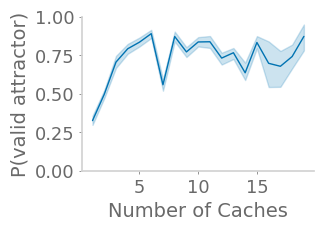

In [96]:
data = pd.DataFrame(results_1)

plt.figure(figsize=(3,2))
sns.lineplot(x='n_caches', y='valid_attractors', data=data[data['recall_strength']==0.75])
plt.xlabel('Number of Caches')
plt.ylabel('P(valid attractor)')
plt.ylim(0, 1.0)
plt.show()

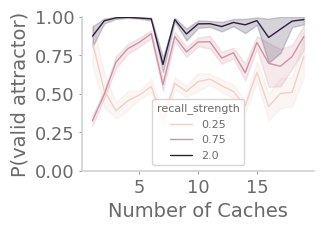

In [97]:
data = pd.DataFrame(results_1)
_data = data[(
    (data['recall_strength'] == 0.25) |\
    (data['recall_strength'] == 0.75) |\
    (data['recall_strength'] == 2.0) 
    )]
plt.figure(figsize=(3,2))
sns.lineplot(x='n_caches', y='valid_attractors', hue='recall_strength', data=_data)
plt.xlabel('Number of Caches')
plt.ylabel('P(valid attractor)')
plt.ylim(0, 1.0)
plt.show()

# Test 2

In [98]:
import importlib
importlib.reload(configs)

<module 'configs' from '/Users/chingfang/Code/barcodes/configs.py'>

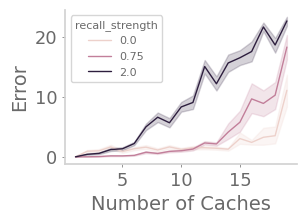

In [99]:
data = pd.DataFrame(results_2B)
_data = data[(
    (data['recall_strength'] == 0.0) |\
    (data['recall_strength'] == 0.75) |\
    (data['recall_strength'] == 2.0) 
    )]
plt.figure(figsize=(3,2))
sns.lineplot(
    x='n_caches', y='chosen attractor dist',
    hue='recall_strength', data=_data)
plt.xlabel('Number of Caches')
plt.ylabel('Error')
plt.show()

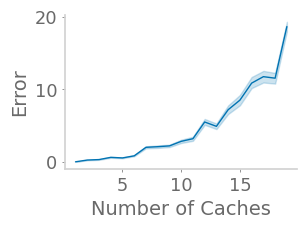

In [100]:
data = pd.DataFrame(results_2B)
plt.figure(figsize=(3,2))
sns.lineplot(x='n_caches', y='chosen attractor dist', data=data)
plt.xlabel('Number of Caches')
plt.ylabel('Error')
plt.show()

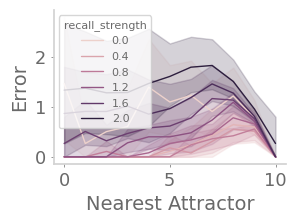

In [101]:
data = pd.DataFrame(results_2B)
data = data[data['n_caches']<=10]
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='chosen attractor dist',
    hue='recall_strength', data=data[data['n_caches']==5])
plt.ylabel('Error')
plt.xlabel('Nearest Attractor')
plt.show()

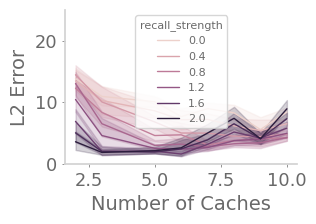

In [102]:
data = pd.DataFrame(results_2C)
data = data[data['n_caches']<=10]
plt.figure(figsize=(3,2))
sns.lineplot(x='n_caches', y='l2 error',
    hue='recall_strength', data=data[data['opt attractor counts']>1])
plt.ylabel('L2 Error')
plt.xlabel('Number of Caches')
plt.ylim(0, 25)
plt.show()

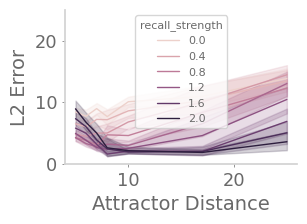

In [103]:
data = pd.DataFrame(results_2C)
data = data[data['n_caches']<=10]
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='l2 error',
    hue='recall_strength', data=data[data['opt attractor counts']>1])
plt.ylabel('L2 Error')
plt.xlabel('Attractor Distance')
plt.ylim(0, 25)
plt.show()

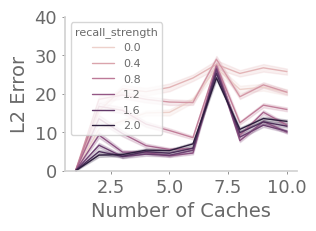

In [106]:
data = pd.DataFrame(results_2D)
data = data[data['n_caches']<=10]
plt.figure(figsize=(3,2))
sns.lineplot(x='n_caches', y='l2 error',
    hue='recall_strength', data=data)
plt.ylabel('L2 Error')
plt.xlabel('Number of Caches')
plt.ylim(0, 40)
plt.show()

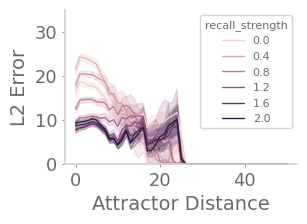

In [107]:
data = pd.DataFrame(results_2D)
data = data[data['n_caches']<=10]
plt.figure(figsize=(3,2))
sns.lineplot(x='opt attractor dist', y='l2 error',
    hue='recall_strength', data=data)
plt.ylabel('L2 Error')
plt.xlabel('Attractor Distance')
plt.ylim(0, 35)
plt.show()

# Test 3

In [64]:
data = pd.DataFrame(results_3)

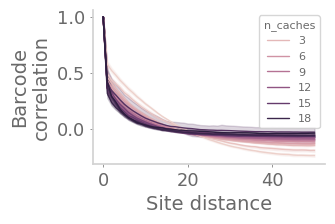

In [65]:
plt.figure(figsize=(3,2))
sns.lineplot(x='distance', y='barcode corr', hue='n_caches', data=data)
plt.xlabel('Site distance')
plt.ylabel('Barcode\ncorrelation')
plt.show()

# Test 4

In [66]:
data = pd.DataFrame(results_4)

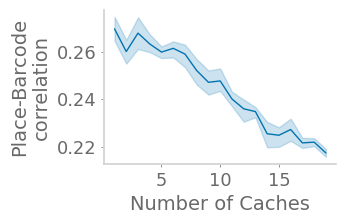

In [67]:
plt.figure(figsize=(3,2))
sns.lineplot(x='n_caches', y='place-barcode corr', data=data)
plt.xlabel('Number of Caches')
plt.ylabel('Place-Barcode\ncorrelation')
plt.show()